## US Graduate Schools Admissions

dataset: https://www.kaggle.com/tanmoyie/us-graduate-schools-admission-parameters

We have the following columns included: 
* GRE Score
* TOEFL Score
* University Rating
* SOP (Statement of Purpose)
* LOR (Letter of Recommendation)
* CGPA (Cummulative GPA)
* Research
* Chance of Admittance - Target variable

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import os
import math

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.linear_model import Ridge, RidgeCV, LinearRegression

In [3]:
# to check if data is normally distributed
from scipy import stats
import statsmodels.api as sm

In [4]:
plt.rcParams['figure.figsize'] = (8,6)
sns.set_style('white')

In [5]:
pd.set_option('expand_frame_repr',True)
pd.set_option('max_rows',80)
pd.set_option('expand_frame_repr',False)

In [6]:
data_path = 'C:\\Users\\gagrocostea\\Box\\Gaby\\Dev\datasets\\'

# read data
data = pd.read_csv(data_path + 'US_graduate_schools_admission_parameters_dataset.csv', encoding = 'utf-8')


### Quick data recap
A quick look at the data tells us that this is a rather small dataset of 400 rows and 9 columns. There is a serial number that we can drop and there are no missing values. Almost all features are numeric - except for Research which is boolean. Universities, letters of recommendation and statements of purpose are all rated from 1 to 5. The target variable is <em>Chance of Admittance</em> which is the probability of getting admitted into graduate school. This what we will try and predict.

In [7]:
print(data.head())

   Serial No.  GRE Score  TOEFL Score  University Rating  SOP  LOR   CGPA  Research  Chance of Admit 
0           1        337          118                  4  4.5   4.5  9.65         1              0.92
1           2        324          107                  4  4.0   4.5  8.87         1              0.76
2           3        316          104                  3  3.0   3.5  8.00         1              0.72
3           4        322          110                  3  3.5   2.5  8.67         1              0.80
4           5        314          103                  2  2.0   3.0  8.21         0              0.65


In [8]:
# clean up column names
data.columns = [c.strip().lower().replace(" ","_") for c in data.columns]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 9 columns):
serial_no.           400 non-null int64
gre_score            400 non-null int64
toefl_score          400 non-null int64
university_rating    400 non-null int64
sop                  400 non-null float64
lor                  400 non-null float64
cgpa                 400 non-null float64
research             400 non-null int64
chance_of_admit      400 non-null float64
dtypes: float64(4), int64(5)
memory usage: 28.2 KB


In [9]:
data.describe()

,serial_no.,gre_score,toefl_score,university_rating,sop,lor,cgpa,research,chance_of_admit
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,200.500000,316.807500,107.410000,3.087500,3.400000,3.452500,8.598925,0.547500,0.724350
std,115.614301,11.473646,6.069514,1.143728,1.006869,0.898478,0.596317,0.498362,0.142609
min,1.000000,290.000000,92.000000,1.000000,1.000000,1.000000,6.800000,0.000000,0.340000
25%,100.750000,308.000000,103.000000,2.000000,2.500000,3.000000,8.170000,0.000000,0.640000
50%,200.500000,317.000000,107.000000,3.000000,3.500000,3.500000,8.610000,1.000000,0.730000
75%,300.250000,325.000000,112.000000,4.000000,4.000000,4.000000,9.062500,1.000000,0.830000
max,400.000000,340.000000,120.000000,5.000000,5.000000,5.000000,9.920000,1.000000,0.970000


## 1 - Data Exploration


### Correlations between GRE, TOEFL Scores and Chance Of Admittance

From the pairplot we can see that there is a positive correlation between GRE Scores and chance of being admitted, and the same can be said about TOEFL Scores. GRE scores & TOEFL scores are positively correlated, and chance of being admitted seems evenly distributed.

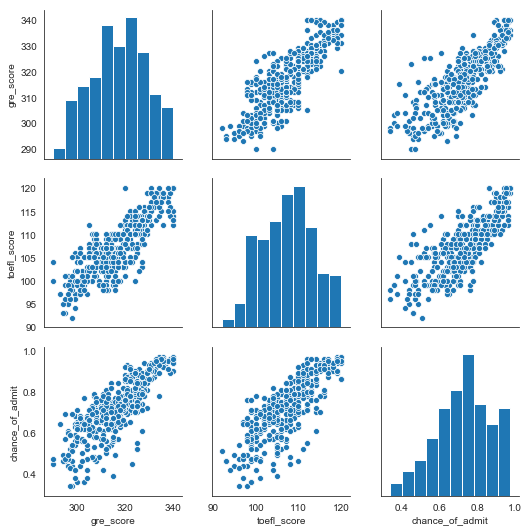

In [10]:
sns.pairplot(data[['gre_score','toefl_score','chance_of_admit']], kind='scatter', palette='Set1')

In [11]:
# correlations
corrmat = data.drop('serial_no.', axis=1).corr()
print(corrmat)

                   gre_score  toefl_score  university_rating       sop       lor      cgpa  research  chance_of_admit
gre_score           1.000000     0.835977           0.668976  0.612831  0.557555  0.833060  0.580391         0.802610
toefl_score         0.835977     1.000000           0.695590  0.657981  0.567721  0.828417  0.489858         0.791594
university_rating   0.668976     0.695590           1.000000  0.734523  0.660123  0.746479  0.447783         0.711250
sop                 0.612831     0.657981           0.734523  1.000000  0.729593  0.718144  0.444029         0.675732
lor                 0.557555     0.567721           0.660123  0.729593  1.000000  0.670211  0.396859         0.669889
cgpa                0.833060     0.828417           0.746479  0.718144  0.670211  1.000000  0.521654         0.873289
research            0.580391     0.489858           0.447783  0.444029  0.396859  0.521654  1.000000         0.553202
chance_of_admit     0.802610     0.791594           0.71

In [12]:
# cumulative GPA has highest correlation
corrmat.sort_values(by = 'chance_of_admit', ascending=False).chance_of_admit

chance_of_admit      1.000000
cgpa                 0.873289
gre_score            0.802610
toefl_score          0.791594
university_rating    0.711250
sop                  0.675732
lor                  0.669889
research             0.553202
Name: chance_of_admit, dtype: float64

<b>Highest Correlations found with target Chance of Admit:</b>

<li>CPGA</li>
<li>GRE Score</li>
<li>TOEFL score</li>
<li>university_rating</li>


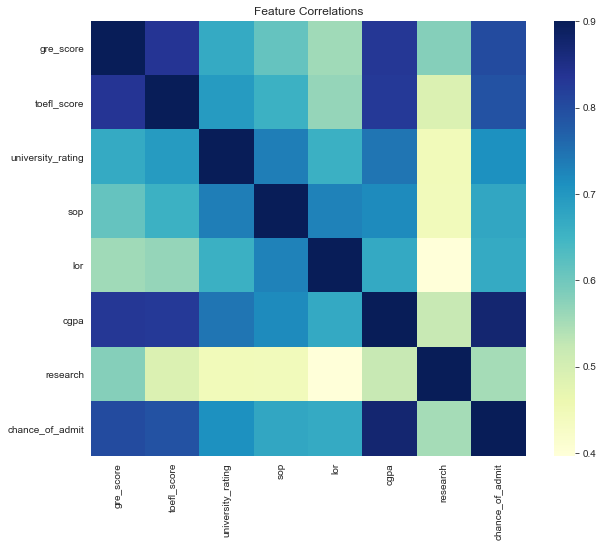

In [13]:
fig, ax = plt.subplots(figsize = (10,8))
_= sns.heatmap(corrmat, vmax=.9,cmap="YlGnBu", square=True, ax=ax)
ax.set_title('Feature Correlations')
plt.show(fig)

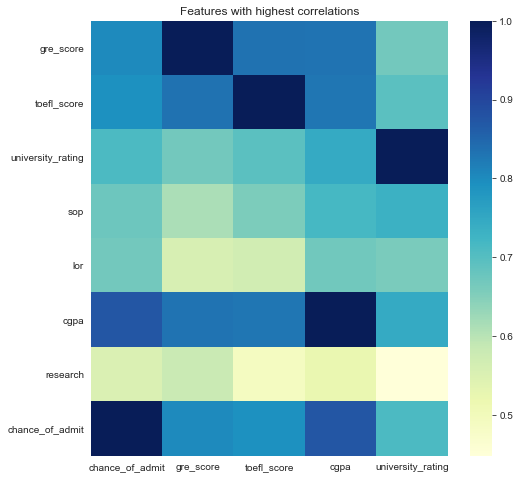

In [14]:
fig, ax = plt.subplots(figsize = (8,8))
_= sns.heatmap(corrmat[['chance_of_admit','gre_score','toefl_score','cgpa','university_rating']], vmax=1.0,
            cmap="YlGnBu", square=False)
ax.set_title('Features with highest correlations')
plt.show(fig)

### What if a student with 50% or more chance of admittance got admitted into grad school?

<em>Spoiler Alert</em> - this is most likely <b>NOT</b> how students are admitted into graduate school. The admittance rate would be greater than 90% in this dataset, so almost anyone would get in...

In [15]:
data['admit'] = [1 if x>=.5 else 0 for x in data.chance_of_admit]

In [16]:
data.head()

,serial_no.,gre_score,toefl_score,university_rating,sop,lor,cgpa,research,chance_of_admit,admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92,1
1,2,324,107,4,4.0,4.5,8.87,1,0.76,1
2,3,316,104,3,3.0,3.5,8.00,1,0.72,1
3,4,322,110,3,3.5,2.5,8.67,1,0.80,1
4,5,314,103,2,2.0,3.0,8.21,0,0.65,1


In [17]:
temp = data.admit.value_counts().reset_index()
temp['threshold'] =.5
#temp = pd.pivot_table(temp, columns=['index'], index='threshold',values='admit')

In [18]:
temp

,index,admit,threshold
0,1,367,0.5
1,0,33,0.5


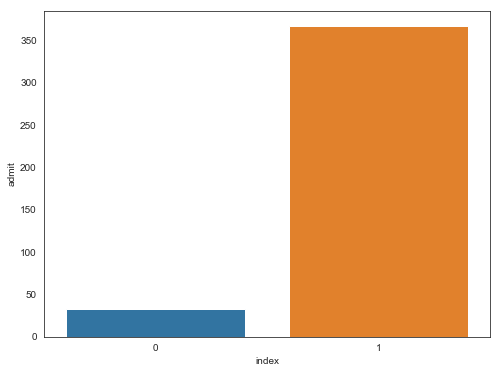

In [19]:
fig, ax = plt.subplots()
sns.barplot(ax=ax, data=temp, y='admit', x='index')
plt.show(fig)

In [20]:
data.drop('admit', axis =1, inplace=True)

### Cumulative GPA and University Rating

1) Plotting the data using distplot

The first plot shows the distribution of the cumulative gpa feature - these scores look normally distributed.
We that as university rating increases so does the cumulative GPA from the scatterplot. There are some students attending universityes with ratings 4 with higher cumulative GPA than those attending the highest rated schools. But in general there is a linear relationship that can be seen as the university rating increases.

2) Plotting the data using qqplot 

This plot generates its own sample of the idealized distribution that we are comparing with, in this case the Gaussian distribution. The idealized normal samples are divided into 5 quantiles, and each data point is paired with a similar sample from the idealized distribution. The X-axis in the plot shows the idealized samples and the Y-axis has the data samples.
Our samples closely fit the expected diagonal pattern for a sample from a Gaussian distribution.

3) Statistical Normality tests

Taking a closer look at this - our null hypothesis H0 states that our sample is normally distributed. <br>We set our alpha to 0.05 and <br>
* if p<= alpha: we reject H0 - not normal
* if p> alpha: fail to reject - normal

a) Shapiro-Wilk test <br>
Evaluates a data sample and quantifies how likely it is to be drawn from a Gaussian distribution.

b) D'Agostino test (stats.normaltest) <br>
This calculates summary statistics on the data: <em>skewness</em> - a measure of asymmetry of the data which quantifies how far left/right the data is pushed. <em>Kurtosis</em> quantifies how much of the data is in the tail of the distribution.

In both cases, from  the given evidence that we have with this dataset, it looks like our null hypothesis is very likely true - our Cumulative GPA scores are <b>normally distributed</b>. We can not reject the null hypothese that the data is normall distributed because the p-values are greater than the chosen alpha<br>

In [21]:
data.cgpa.describe()

count    400.000000
mean       8.598925
std        0.596317
min        6.800000
25%        8.170000
50%        8.610000
75%        9.062500
max        9.920000
Name: cgpa, dtype: float64

c:\users\gagrocostea\appdata\local\programs\python\python37-32\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


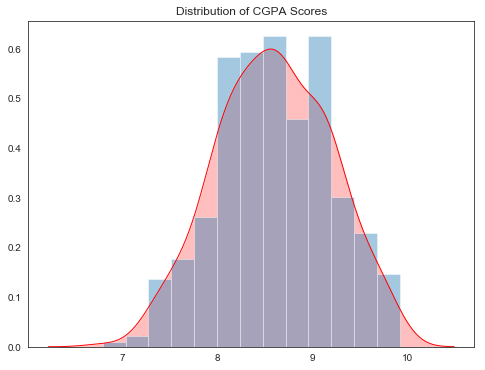

In [22]:
# 1) general plot of data distribution
fig, ax = plt.subplots()
_ = sns.distplot(data.cgpa, kde=True, kde_kws={'color':'red', 'shade':True, 'lw':1}, ax=ax)
ax.set_xlabel('')
ax.set_title("Distribution of CGPA Scores")
plt.show(fig)

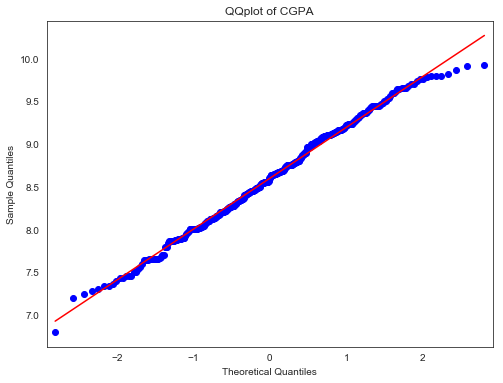

In [23]:
# 2) qqplot
from statsmodels.graphics.gofplots import qqplot
fig, ax = plt.subplots()
_ = qqplot(data.cgpa, line = 's', ax=ax)
ax.set_title("QQplot of CGPA")
plt.show(fig)

In [24]:
# 3) a) Shapiro normality test
statistic, p = stats.shapiro(x=data.cgpa)
print('Statistics=%.3f, p=%.3f' % (statistic, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Our data sample looks Gaussian (fail to reject H0)')
else:
    print('Our data sample does not look Gaussian (reject H0)')

Statistics=0.993, p=0.072
Our data sample looks Gaussian (fail to reject H0)


In [25]:
#3) b) D’Agostino’s K^2 Test - test for skewness & kurtosis
alpha = 5e-2
print("Chosen alpha is: %.4f" %alpha)
k2, p = stats.normaltest(data.cgpa)
print("p value is", p)


Chosen alpha is: 0.0500
p value is 0.052520729609327604


In [26]:
# null hypothesis: scores come from a normal distribution
if p < alpha:  
    print("The null hypothesis can be rejected - our data is likely NOT normal")
else:
    print("The null hypothesis cannot be rejected - our data is likely normal")
#The null hypothesis can be rejected


The null hypothesis cannot be rejected - our data is likely normal


### University Ratings - A quick look
Univeristy ratings of 2 and 3 make up about 50% of the data. We can also see that university ratings and cumulative gpa increase together - which makes sense. 

In [27]:
temp = pd.DataFrame(data.university_rating.value_counts())
temp.columns = ['row_count']
temp.index.name = 'university_rating'
temp.reset_index(inplace=True)
temp['percent'] = temp.row_count/temp.shape[0]
temp

,university_rating,row_count,percent
0,3,133,26.6
1,2,107,21.4
2,4,74,14.8
3,5,60,12.0
4,1,26,5.2


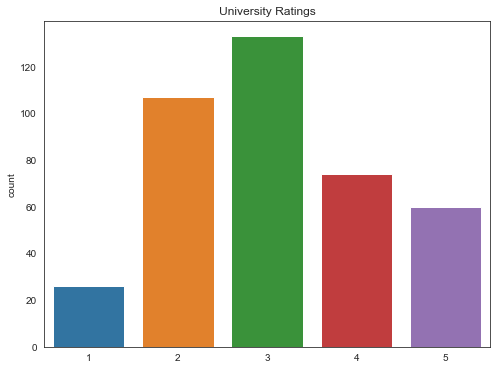

In [28]:
temp = pd.DataFrame(data.university_rating.value_counts())
temp.columns = ['count']
temp.index.name = 'university_rating'
temp.reset_index(inplace=True)
temp

fig, ax = plt.subplots()
_ =sns.barplot(data = temp, y='count', x = 'university_rating', ax = ax)
ax.set_title("University Ratings")
ax.set_xlabel("")
plt.show(fig)

c:\users\gagrocostea\appdata\local\programs\python\python37-32\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


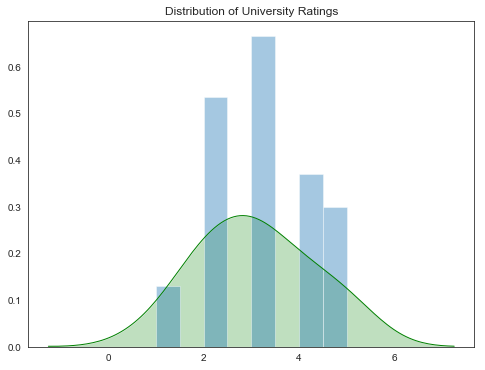

In [29]:
fig, ax = plt.subplots()
_ = sns.distplot(data.university_rating, kde=True, kde_kws={'color':'green', 'shade':True, 'lw':1, 'bw':.75}, ax=ax)
ax.set_xlabel('')
ax.set_title("Distribution of University Ratings")
plt.show(fig)

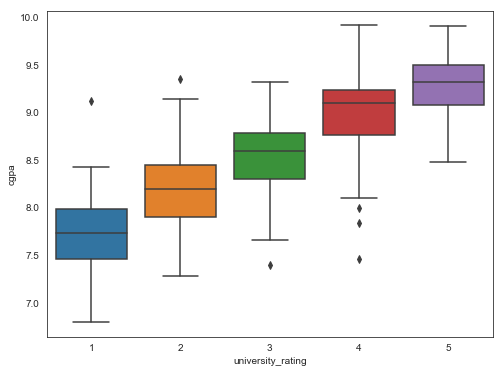

In [30]:
fig, ax = plt.subplots()
_ = sns.boxplot(ax=ax, data=data, x= 'university_rating', y= 'cgpa')

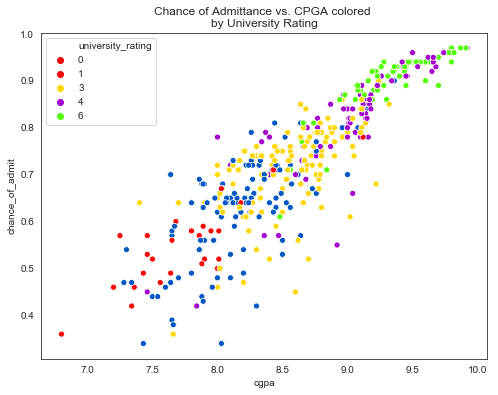

In [31]:
fig, ax = plt.subplots()
_ = sns.scatterplot(data = data, x ='cgpa', y='chance_of_admit', hue = 'university_rating',
                palette='prism',x_jitter=True, y_jitter=True, ax = ax)
ax.set_title("Chance of Admittance vs. CPGA colored \nby University Rating")
plt.show(fig)

### GRE & TOEFL Scores and Research 

Overall GRE score percentiles are higher for those students with research than that of students who do not have research. 
From the boxplot we can see that the highest GRE scores belong to students with research experience and they also are highest in chance of getting admitted. We see a similar situation with TOEFL scores.

In [32]:
data.groupby(['research']).gre_score.describe()

,count,mean,std,min,25%,50%,75%,max
research,,,,,,,,
0,181.0,309.491713,8.774723,290.0,303.0,310.0,315.0,339.0
1,219.0,322.853881,9.808563,293.0,317.0,324.0,329.0,340.0


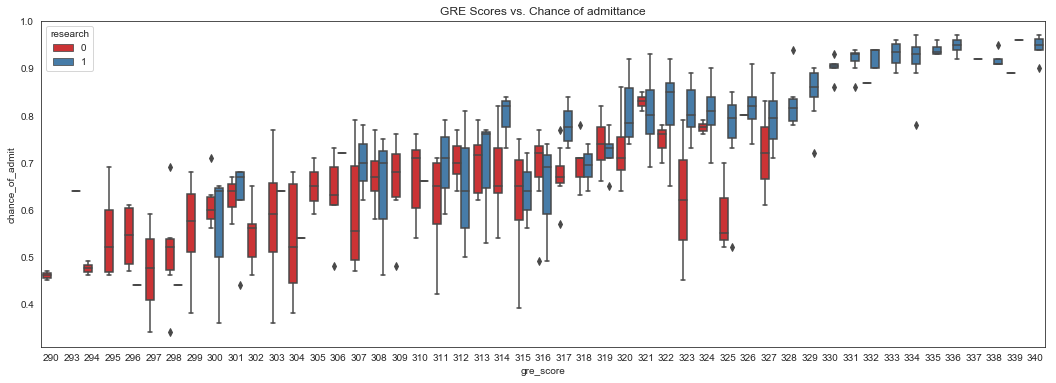

In [33]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize =(18,6))
_ = sns.boxplot(data=data, x = 'gre_score', y = 'chance_of_admit', hue='research', ax = ax, palette='Set1')
ax.set_title("GRE Scores vs. Chance of admittance")
plt.show(fig)

In [34]:
data.groupby(['research']).toefl_score.describe()

,count,mean,std,min,25%,50%,75%,max
research,,,,,,,,
0,181.0,104.143646,4.842098,92.0,101.0,104.0,107.0,120.0
1,219.0,110.109589,5.646859,95.0,107.0,110.0,114.0,120.0


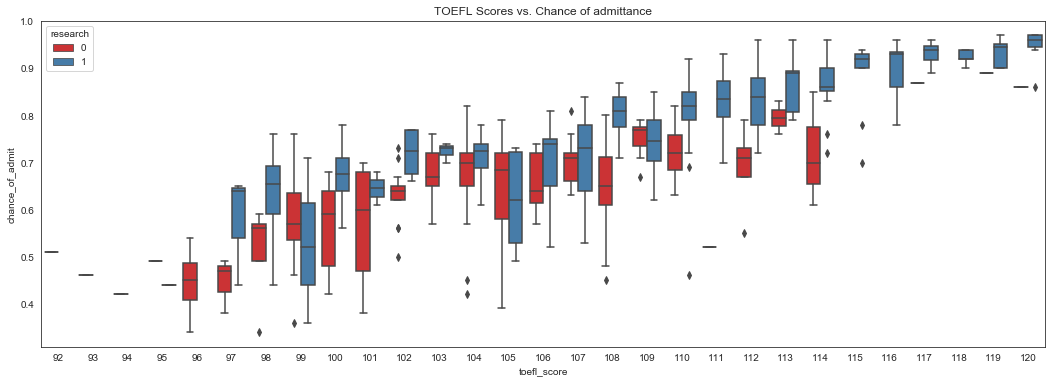

In [35]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize =(18,6))
_ = sns.boxplot(data=data, x = 'toefl_score', y = 'chance_of_admit', hue='research', ax = ax, palette='Set1')
ax.set_title("TOEFL Scores vs. Chance of admittance")
plt.show(fig)

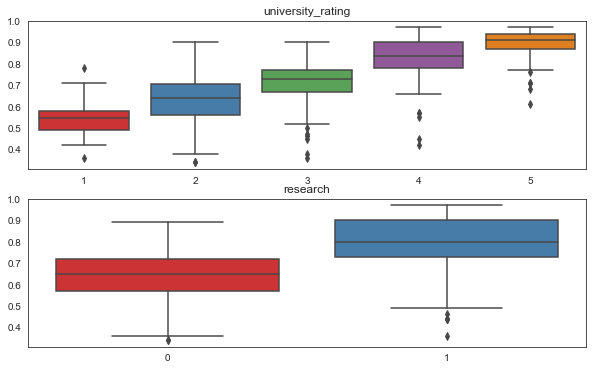

In [36]:
'''
    Box plots of University Rating & Research vs chance of admittance
        - Need to scale data - GRE & TOEFL since these are not on the same scale
'''
var = ['university_rating','research']
fig, axes = plt.subplots(figsize=(10, 6),nrows=2)
for i, v in enumerate(var):
    sns.boxplot(y = 'chance_of_admit', x =v, ax = axes[i], data=data[[v, 'chance_of_admit']], palette='Set1')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].set_title(v)
plt.show(fig)

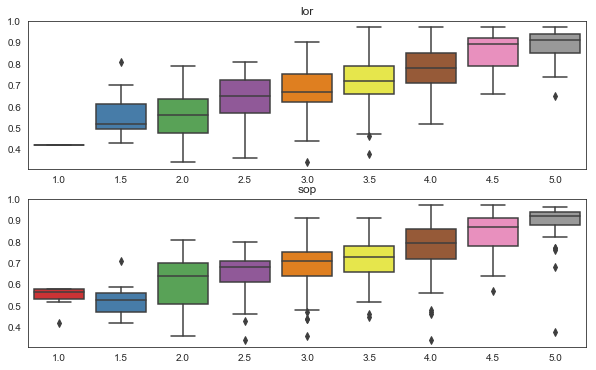

In [37]:
'''
    Box plots of Letter of Recommendation & Statement of Purpose vs chance of admittance
'''
var = ['lor','sop']
fig, axes = plt.subplots(figsize=(10, 6),nrows=2)
for i, v in enumerate(var):
    sns.boxplot(y = 'chance_of_admit', x =v, ax = axes[i], data=data[[v, 'chance_of_admit']], palette='Set1')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].set_title(v)
plt.show(fig)

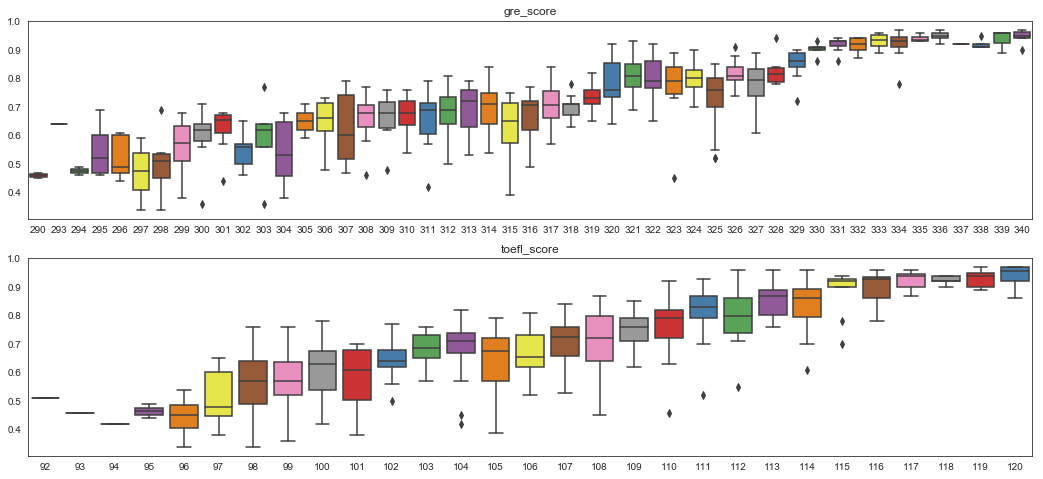

In [38]:
'''
    Box plots of GRE & TOEFL Scores vs chance of admittance
        - Need to scale GRE & TOEFL since these are not on the same scale
'''
var = ['gre_score','toefl_score']
fig, axes = plt.subplots(figsize=(18, 8),nrows=2)
for i, v in enumerate(var):
    sns.boxplot(y = 'chance_of_admit', x =v, ax = axes[i], data=data[[v, 'chance_of_admit']], palette='Set1')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].set_title(v)
plt.show(fig)

## 2 - Pedicting the chance of being admitted to graduate school - Linear Regression

### Model 1 - Linear Regression with training and test set
<br>
Using 360 rows of data for training and 40 for testing, we scale the data using the standardscaler (mean = 0 and variance = 1) and then fit a linear regression model to the data. 

The first model gets an R^2 score is 0.78, which means that about 78% of the variability in Y can be explained using X. <br>
When looking at RMSE, we are an average of 6% chance of admittance away from the ground truth when making predictions on our test set. 

The features with the highest coefficients are <em>Cumulative GPA & TOEFL Score</em> which indicates that they have the most influence on the chance of getting admitted to graduate school in this model.

In [39]:
data.head()

,serial_no.,gre_score,toefl_score,university_rating,sop,lor,cgpa,research,chance_of_admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


In [40]:
# shuffle data
X, y = shuffle(data.drop(['serial_no.','chance_of_admit'], axis=1), data.chance_of_admit, random_state=23)

In [41]:
# split data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=1)

In [42]:
print(X_train.shape)
print('%d rows of training data' % X_train.shape[0])

(360, 7)
360 rows of training data


In [43]:
# suppress conversion errors
from sklearn.exceptions import DataConversionWarning
import warnings
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [44]:
# use Linear regression to predict target
linreg = LinearRegression()
scaler = preprocessing.StandardScaler()

In [45]:
# fit scaler on training data
scaler = scaler.fit(X_train)
# transform training data using standard scaler
X_train_transformed = scaler.transform(X_train)

# transform test data fit scaler
X_test_transformed = scaler.transform(X_test)

# fit model to training data
linreg = linreg.fit(X_train_transformed, y_train)

In [46]:
linreg_score = linreg.score(X_test_transformed, y_test)
print("Linear Regression R^2 score on training set %.4f" %linreg.score(X_train_transformed,y_train))
print("Linear Regression R^2 score on test set     %.4f" %linreg_score)

pred = linreg.predict(X_test_transformed)
linreg_mse = mean_squared_error(y_pred=pred, y_true=y_test)
print("Linear Regression MSE score on training %.4f" %linreg_mse)
print("Linear Regression RMSE %.4f" %math.sqrt(linreg_mse))


Linear Regression R^2 score on training set 0.8025
Linear Regression R^2 score on test set     0.7881
Linear Regression MSE score on training 0.0040
Linear Regression RMSE 0.0631


In [47]:
# look at coefficients - which variables are most important in model?
linreg_coefs = linreg.coef_
coef_df = pd.DataFrame(data = list(zip(X_train.columns,linreg_coefs)), columns=['feature','coefficient'])
coef_df.sort_values(by = 'coefficient', ascending=False)

,feature,coefficient
5,cgpa,0.070619
1,toefl_score,0.020241
4,lor,0.019396
0,gre_score,0.017442
6,research,0.014512
2,university_rating,0.004500
3,sop,-0.001821


### Model 2 - Linear Regression using 10-fold cross validation
In the second model I created a pipeline to scale the date, fit it and perform cross validation. <br>The average training and test R^2 score remained quite the same at 80% and 78%.

In [62]:
# build pipeline to combine standard scaler and Linear Regression
scaler = preprocessing.StandardScaler()
linreg_pipe = Pipeline(steps=[('standardscaler', scaler ),('linear', LinearRegression())])

In [63]:
scores = cross_validate(return_train_score=True, error_score=True,
                        estimator=linreg_pipe, X=X ,y=y, cv=10)
print(scores)

{'fit_time': array([0.01304197, 0.00401211, 0.00552583, 0.00451183, 0.00752997,
       0.01004672, 0.00551558, 0.00351048, 0.00454402, 0.00451088]), 'score_time': array([0.00250554, 0.00150442, 0.00200438, 0.00150347, 0.00150371,
       0.00150442, 0.00300717, 0.00200438, 0.0009706 , 0.00150466]), 'test_score': array([0.72835965, 0.73714592, 0.87183514, 0.80379514, 0.81545097,
       0.73894106, 0.7618908 , 0.72425731, 0.80234485, 0.80944669]), 'train_score': array([0.80884704, 0.80773844, 0.79167226, 0.80258291, 0.80200557,
       0.80578924, 0.80802737, 0.80802246, 0.80200763, 0.80139747])}


In [65]:
print("Average score for train: %.4f" %scores['train_score'].mean())
print("Average score for test:  %.4f" %scores['test_score'].mean())

Average score for train: 0.8038
Average score for test:  0.7793


### Model 3 - Ridge Regression

For this model I performed cross valiation in 2 ways: 

<em>1) 5-Fold cross validation by looping</em>

I looped through an array of alpha values and performed 5-fold cross validation and assigned that alpha to the Ridge regression model. I did this to then plot alpha vs the average CV score for that fold, where we can see that the optimal alpha gives the best score of 0.785.

<em>2) 5-Fold cross validation using RidgeCV</em>

Here the average R^2 score was very close at 0.788. Using the returned coefficients, the cumulative gpa is seemingly the most informative feature followed by TOEFL scores. Since GRE and TOEFL scores are highly correlated, I think the model would perform similiarly with GRE or TOEFL scores... 

In [51]:
from sklearn.linear_model import Ridge
ridge = Ridge()

******************************
CROSS VALIDATION/K-FOLD FOR RIDGE REGRESSION
******************************


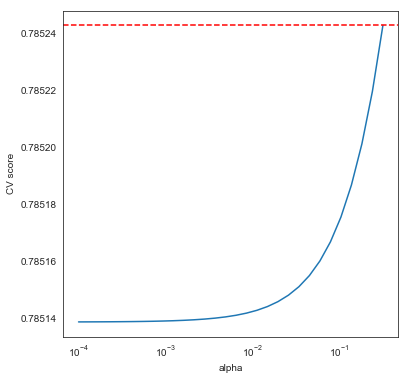

In [52]:
print("*"*30)
print("CROSS VALIDATION/K-FOLD FOR RIDGE REGRESSION")
print("*"*30)

alphas = np.logspace(-4, -.5, 30)
#alphas=[0.1, 1.0, 20.0]
scores = list()
scores_std = list()
for alpha in alphas:
    ridge.alpha = alpha
    this_scores = cross_val_score(estimator = ridge, X=X, y=y, n_jobs=1, cv=5)
    scores.append(np.mean(this_scores))
    scores_std.append(np.std(this_scores))

plt.figure(figsize=(6, 6))
plt.semilogx(alphas, scores)
plt.ylabel('CV score')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='red')
plt.show()

In [53]:
cv=5
ridge_cv = RidgeCV(alphas=alphas, cv=5)

# fit Ridge Regression using 5fold cross validation
ridge_cv.fit(X_train_transformed, y_train)

RidgeCV(alphas=array([1.00000e-04, 1.32035e-04, 1.74333e-04, 2.30181e-04, 3.03920e-04,
       4.01281e-04, 5.29832e-04, 6.99564e-04, 9.23671e-04, 1.21957e-03,
       1.61026e-03, 2.12611e-03, 2.80722e-03, 3.70651e-03, 4.89390e-03,
       6.46167e-03, 8.53168e-03, 1.12648e-02, 1.48735e-02, 1.96383e-02,
       2.59294e-02, 3.42360e-02, 4.52035e-02, 5.96846e-02, 7.88046e-02,
       1.04050e-01, 1.37382e-01, 1.81393e-01, 2.39503e-01, 3.16228e-01]),
    cv=5, fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
    store_cv_values=False)

In [54]:
ridge_cv_score = ridge_cv.score(X_test_transformed, y_test)
print("Ridge Regression R^2 score %.4f" %ridge_cv_score)

ridge_cv_pred = ridge_cv.predict(X_test_transformed)
ridge_cv_mse = mean_squared_error(y_pred=ridge_cv_pred, y_true=y_test)

print("Ridge Regression MSE score %.4f" %ridge_cv_mse)
print("Ridge Regression RMSE %.4f" %math.sqrt(ridge_cv_mse))

Ridge Regression R^2 score 0.7881
Ridge Regression MSE score 0.0040
Ridge Regression RMSE 0.0631


In [55]:
ridge_cv_coefs = ridge_cv.coef_
ridge_coef_df = pd.DataFrame(data = list(zip(X_train.columns, ridge_cv_coefs)), columns=['feature','coefficient'])
print(ridge_coef_df.sort_values(by = 'coefficient', ascending=False))

             feature  coefficient
5               cgpa     0.070369
1        toefl_score     0.020283
4                lor     0.019390
0          gre_score     0.017534
6           research     0.014506
2  university_rating     0.004548
3                sop    -0.001752


### Ridge Regression with best features: CGPA, TOEFL & GRE Scores
Lastly, I fit ridge regression models for Cumulative GPA, TOEFL & Score scores and then separately using Cumulative GPA and one of the two scores since these are highly correlative. The highest scoring model in the case of GRE vs TOEFL was GRE at 79% R^2.

In [56]:
# fit scaler on training data - CPGA, GRE & TOEFL
scaler_2 = preprocessing.StandardScaler()
scaler_2.fit(X_train[['cgpa','gre_score','toefl_score']])

# transform training data using standard scaler
X_train_transformed_2 = scaler_2.transform(X_train[['cgpa','gre_score','toefl_score']])
X_test_transformed_2 = scaler_2.transform(X_test[['cgpa','gre_score','toefl_score']])

In [57]:
# fit Ridge Regression using 5-fold cross validation
ridge_2 = RidgeCV(alphas=alphas, cv=5)
ridge_2.fit(X_train_transformed_2, y_train)

RidgeCV(alphas=array([1.00000e-04, 1.32035e-04, 1.74333e-04, 2.30181e-04, 3.03920e-04,
       4.01281e-04, 5.29832e-04, 6.99564e-04, 9.23671e-04, 1.21957e-03,
       1.61026e-03, 2.12611e-03, 2.80722e-03, 3.70651e-03, 4.89390e-03,
       6.46167e-03, 8.53168e-03, 1.12648e-02, 1.48735e-02, 1.96383e-02,
       2.59294e-02, 3.42360e-02, 4.52035e-02, 5.96846e-02, 7.88046e-02,
       1.04050e-01, 1.37382e-01, 1.81393e-01, 2.39503e-01, 3.16228e-01]),
    cv=5, fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
    store_cv_values=False)

In [58]:
ridge_2_score = ridge_2.score(X_test_transformed_2, y_test)
print("Ridge Regression R^2 score %.4f" % ridge_2_score)

ridge_2_pred = ridge_2.predict(X_test_transformed_2)
ridge_2_mse = mean_squared_error(y_pred=ridge_2_pred, y_true=y_test)

print("Ridge Regression MSE score %.4f" %ridge_cv_mse)
print("Ridge Regression RMSE %.4f" %math.sqrt(ridge_cv_mse))

Ridge Regression R^2 score 0.7894
Ridge Regression MSE score 0.0040
Ridge Regression RMSE 0.0631


In [59]:
ridge_2_coefs = ridge_2.coef_
ridge_2_coef_df = pd.DataFrame(data = list(zip(X_train.columns, ridge_2_coefs)), columns=['feature','coefficient'])
print(ridge_2_coef_df.sort_values(by = 'coefficient', ascending=False))

             feature  coefficient
0          gre_score     0.085242
1        toefl_score     0.024939
2  university_rating     0.021484


### Model with GRE Score and with TOEFL Score - which is better?

In [60]:
features = ['gre_score','toefl_score']

new_scaler = preprocessing.StandardScaler()


for feat in features:
    feature_list = ['cgpa']
    feature_list.append(feat)
    new_scaler.fit(X_train[feature_list])
    X_train_scaled = new_scaler.transform(X_train[feature_list])
    X_test_scaled = new_scaler.transform(X_test[feature_list])
    
    # fit Ridge Regression using 5-fold cross validation - CPGA & GRE
    ridge_new = RidgeCV(alphas=alphas, cv=5)
    ridge_new.fit(X_train_scaled, y_train)
    score_new = ridge_new.score(X_test_scaled, y_test)
    print("Ridge Regression model using %s is: R^2 score %.4f" %(feat,score_new))  

Ridge Regression model using gre_score is: R^2 score 0.7978
Ridge Regression model using toefl_score is: R^2 score 0.7765


In [66]:
pred_ridge_new = ridge_new.predict(X_test_scaled)

In [68]:
# make predictions on test data
X_test['predictions'] = pred_ridge_new

c:\users\gagrocostea\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [141]:
# merge predictions & look at rows with highest squared difference
predicted_test = X_test.merge(pd.DataFrame(y_test), right_index = True, left_index=True)
predicted_test['diff_squared'] = predicted_test.apply(lambda x: (x['predictions']-x['chance_of_admit'])**2, axis=1)
predicted_test.sort_values(by = 'diff_squared', ascending=False)[['toefl_score','chance_of_admit','predictions','diff_squared']].head(5)


,toefl_score,chance_of_admit,predictions,diff_squared
40,110,0.46,0.639608,0.032259
358,105,0.70,0.553767,0.021384
63,107,0.56,0.705240,0.021095
360,110,0.85,0.744311,0.011170
186,107,0.84,0.734688,0.011091


In [139]:
X_train.describe()

,gre_score,toefl_score,university_rating,sop,lor,cgpa,research
count,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000
mean,316.583333,107.197222,3.063889,3.397222,3.443056,8.582028,0.538889
std,11.479605,6.073138,1.143628,1.007904,0.884850,0.591979,0.499179
min,290.000000,92.000000,1.000000,1.000000,1.000000,6.800000,0.000000
25%,308.000000,103.000000,2.000000,2.500000,3.000000,8.157500,0.000000
50%,317.000000,107.000000,3.000000,3.500000,3.500000,8.565000,1.000000
75%,325.000000,111.000000,4.000000,4.000000,4.000000,9.040000,1.000000
max,340.000000,120.000000,5.000000,5.000000,5.000000,9.920000,1.000000
